In [83]:
%matplotlib inline
from IPython.display import display

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy import stats
import sys
import math

## Find and parse real and baseline layout files
Files are not neatly organized 

In [84]:
dataset_id = "calcuta" # Program argument

In [85]:
rectangles_dirs = [d[0] for d in os.walk("../rectangles/")]
rectangles_dirs.sort()
baseline_dirs = [d for d in rectangles_dirs if dataset_id in d and "baseLine" in d]
real_dirs = [d for d in rectangles_dirs if dataset_id in d and "baseLine" not in d]

In [86]:
real_dirs

['../rectangles/ApproximationTreeMap/calcuta.data',
 '../rectangles/HilbertTreeMap/calcuta.data',
 '../rectangles/IncrementalLayoutWithMoves/calcuta.data',
 '../rectangles/IncrementalLayoutWithoutMoves/calcuta.data',
 '../rectangles/MooreTreeMap/calcuta.data',
 '../rectangles/PivotByMiddle/calcuta.data',
 '../rectangles/PivotBySize/calcuta.data',
 '../rectangles/PivotBySplit/calcuta.data',
 '../rectangles/SliceAndDice/calcuta.data',
 '../rectangles/SpiralTreeMap/calcuta.data',
 '../rectangles/SquarifiedTreeMap/calcuta.data',
 '../rectangles/StripTreeMap/calcuta.data']

In [87]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [88]:
technique_ids = []
rectangles = {}
for i in range(len(real_dirs)):
    # Match technique name from path
    match = re.match("../rectangles/(\w+)", real_dirs[i])
    technique_id = ''
    if match:
        technique_id = match.group(1)
        technique_ids.append(technique_id)
    else:
        print("Invalid path: ", real_dirs[i])
    
    real_rectangles_paths = [os.path.join(real_dirs[i], f) for f in os.listdir(real_dirs[i]) if os.path.isfile(os.path.join(real_dirs[i], f))]
    real_rectangles_paths = natural_sort(real_rectangles_paths)
    baseline_rectangles_paths = [os.path.join(baseline_dirs[i], f) for f in os.listdir(baseline_dirs[i]) if os.path.isfile(os.path.join(baseline_dirs[i], f))]
    baseline_rectangles_paths = natural_sort(baseline_rectangles_paths)
    
    dataframes = []
    # Real i matches with Baseline i-1 
    # Revision 0 doesn't have a Baseline, but we'll need the Real layout for Aspect Ratio statistics 
    
    real_df = pd.read_csv(real_rectangles_paths[0], header=None)
    column_names = ['id', 'rx', 'ry', 'rw', 'rh']
    real_df.columns = column_names
    real_df.set_index('id', inplace=True)
    dataframes.append(real_df)
    
    # Read remaining revisions
    for j in range(len(real_rectangles_paths) - 1):
        # print(real_rectangles_paths[j+1], baseline_rectangles_paths[j])
        # Read Real
        column_names = ['id', 'rx', 'ry', 'rw', 'rh']
        real_df = pd.read_csv(real_rectangles_paths[j+1], header=None)
        real_df.columns = column_names
        real_df.set_index('id', inplace=True)
        # Read Baseline
        # print(baseline_rectangles_paths[j])
        column_names = ['id', 'bx', 'by', 'bw', 'bh']
        baseline_df = pd.read_csv(baseline_rectangles_paths[j], header=None)
        baseline_df.columns = column_names
        baseline_df.set_index('id', inplace=True)
        
        df = pd.concat([real_df, baseline_df], axis=1, join='inner')
        dataframes.append(df)
        
    rectangles[technique_id] = dataframes
    

In [89]:
# display(rectangles["StripTreeMap"][95].head())
# display(rectangles["StripTreeMap"][96].head())
n_revisions = len(rectangles["ApproximationTreeMap"])
technique_ids

['ApproximationTreeMap',
 'HilbertTreeMap',
 'IncrementalLayoutWithMoves',
 'IncrementalLayoutWithoutMoves',
 'MooreTreeMap',
 'PivotByMiddle',
 'PivotBySize',
 'PivotBySplit',
 'SliceAndDice',
 'SpiralTreeMap',
 'SquarifiedTreeMap',
 'StripTreeMap']

# Compute Aspect Ratios

In [90]:
def styleBoxplot(bp, ax, n_revisions):
    
    def get_ax_size(ax):
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        width, height = bbox.width, bbox.height
        width *= fig.dpi
        height *= fig.dpi
        return width, height
    
    for box in bp['boxes']:
        # change outline color
        box.set(color='#1b9e77',
                linewidth=0,
                path_effects=[pe.Stroke(linewidth=0.1, foreground='#1b9e77'), pe.Normal()],
                facecolor='#1b9e77')
        box.set_zorder(10)
    for i, median in enumerate(bp['medians']):
        median.set(color='#000000', 
                   linewidth=2, 
                   solid_capstyle="butt", 
                   ms=(get_ax_size(ax)[0])/(n_revisions))
        median.set_zorder(11)
        #median.set_xdata([i + 1 - 0.3, i + 1 + 0.3])
    for whisker in bp['whiskers']:
        whisker.set(color='#CCCCCC',
                    linestyle='-', 
                    solid_capstyle="butt")
        whisker.set_path_effects([pe.PathPatchEffect(edgecolor='#CCCCCC', linewidth=((get_ax_size(ax)[0])/(n_revisions))*1.08,
                                                 facecolor='black')])
    for cap in bp['caps']:
        cap.set(color='#FFFFFF', linewidth=0)
        
    # Set only 3 ticks on x
    ax.set_xticks([1, n_revisions / 2, n_revisions], minor=False)
    # ax.set_xticklabels([1, int(n_revisions / 2), n_revisions], fontdict=None, minor=False)
    ax.set_xticklabels(["", "", ""], fontdict=None, minor=False)
    
    # Remove extra spines and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_zorder(100)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', top='off', direction='out')
    ax.tick_params(axis='y', which='both', right='off', left='on', direction='out')

In [91]:
technique_ids
np.median([1,2,3,4,5])

3.0

ApproximationTreeMap
HilbertTreeMap
IncrementalLayoutWithMoves
IncrementalLayoutWithoutMoves
MooreTreeMap
PivotByMiddle
PivotBySize
PivotBySplit
SliceAndDice
SpiralTreeMap
SquarifiedTreeMap
StripTreeMap


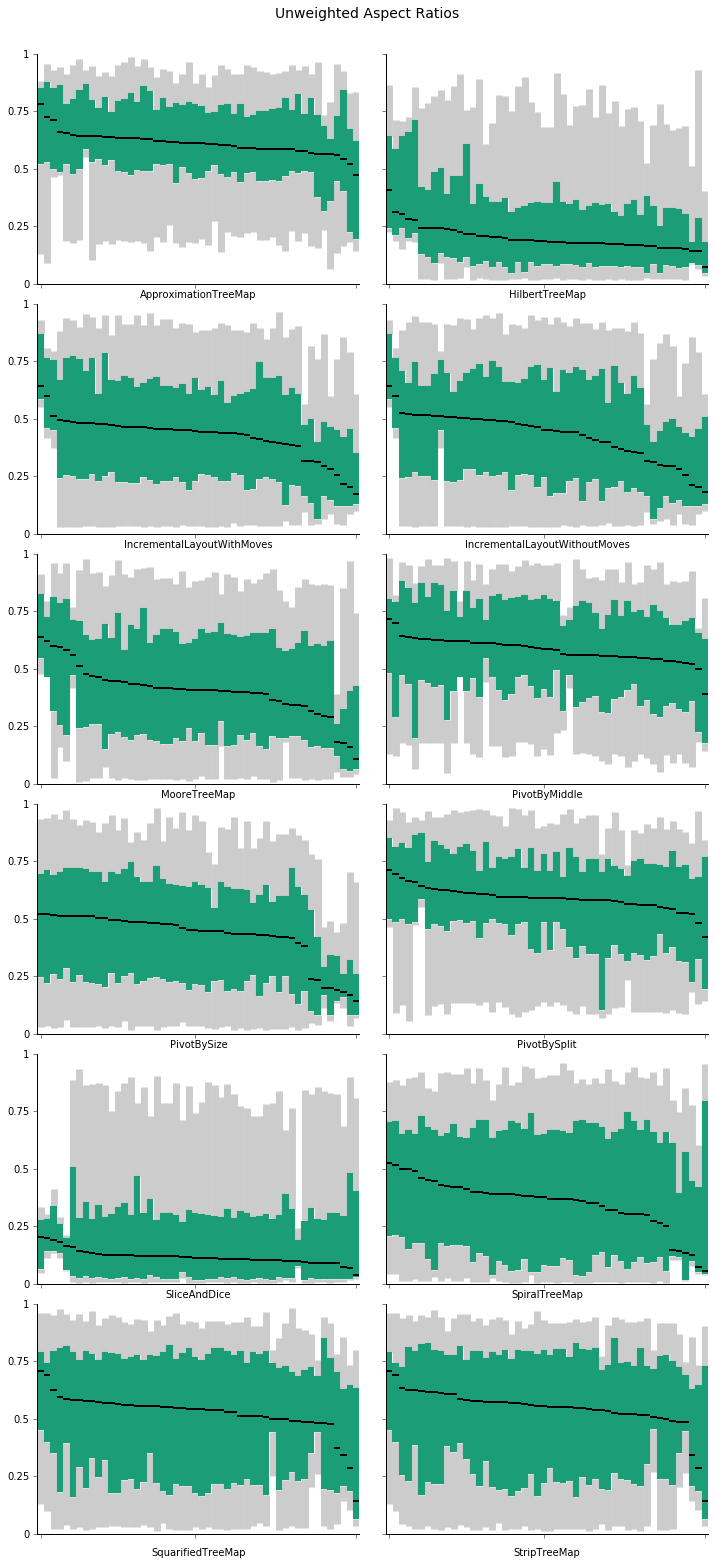

In [92]:
nrow = 6
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, 22))
#fig.delaxes(axs[5, 1])
fig.suptitle('Unweighted Aspect Ratios', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, ax in enumerate(fig.axes):
    technique = technique_ids[i]
    #ax.set_title(technique)
    ax.set_xlabel(technique)    

    print(technique)

    data = []
    for revision in range(n_revisions):
        df = rectangles[technique][revision]
        ars = df[['rw', 'rh']].min(axis=1) / df[['rw', 'rh']].max(axis=1)
        data.append(ars)
        
    data.sort(key=lambda x: -np.median(x))
    bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);

    ax.set_ylim(ymin=-0, ymax=1)
    ax.set_yticks([0, .25, .5, .75, 1], minor=False)
    ax.set_yticklabels([0, .25, .5, .75, 1], fontdict=None, minor=False)
    styleBoxplot(bp, ax, len(data))
    

# s = "Aspect Ratio\nDataset: " + dataset_id
# fig.axes[11].text(4, .9, s, fontsize=12)
# # Remove extra spines and ticks
# fig.axes[11].spines['top'].set_visible(False)
# fig.axes[11].spines['bottom'].set_visible(False)
# fig.axes[11].spines['left'].set_visible(False)
# fig.axes[11].spines['right'].set_visible(False)
# fig.axes[11].tick_params(axis='x', which='both', top='off', bottom='off', labelbottom='off')
# fig.axes[11].tick_params(axis='y', which='both', right='off', left='off')

# fig.savefig('./boxplots/svg/' + dataset_id + "_ar" + '.svg')
# fig.savefig('./boxplots/png/' + dataset_id + "_ar" + '.png')


# Compute Baseline Stability

In [93]:
def point_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def corner_travel(*args):
    x1, y1, w1, h1, x2, y2, w2, h2 = args
    if math.isnan(w1):
        # 2 times the hypotenuse -- growth from center
        return 2 * math.sqrt(w2 ** 2 + h2 ** 2)
    elif math.isnan(w2):
        return 2 * math.sqrt(w1 ** 2 + h1 ** 2)
    else:
        return point_distance(x1, y1, x2, y2)   \
            + point_distance(x1 + w1, y1, x2 + w2, y2)   \
            + point_distance(x1, y1 + h1, x2, y2 + h2)   \
            + point_distance(x1 + w1, y1 + h1, x2 + w2, y2 + h2)

            
def baseline_ratio_stability(df0, df1, bl1):
    
    # Create dataframes with real coordinates and real-baseline coordinates
    dfr = pd.merge(df0, df1, how='outer', left_index=True, right_index=True)
    dfb = pd.merge(df0, bl1, how='outer', left_index=True, right_index=True)
    
    r_m = dfr.apply(lambda r: corner_travel(*list(r)), axis=1)
    b_m = dfb.apply(lambda r: corner_travel(*list(r)), axis=1)
    

    results = pd.concat([r_m, b_m], axis=1, join='inner')
    results.columns = ['real', 'baseline']
    results['stab'] = results['baseline'] / results[['baseline', 'real']].max(axis=1)
    # display(results)
    return results['stab'].values.tolist()


def baseline_diff_stability(df0, df1, bl1):
    # Normalize by 4 * hypotenuse
    base_width = (df0['rx'] + df1['rw']).max()
    base_height = (df0['ry'] + df1['rh']).max()
    norm = 4 * math.sqrt(base_width ** 2 + base_height ** 2)

    # Create dataframes with real coordinates and real-baseline coordinates
    dfr = pd.merge(df0, df1, how='outer', left_index=True, right_index=True)
    dfb = pd.merge(df0, bl1, how='outer', left_index=True, right_index=True)
    
    r_m = dfr.apply(lambda r: corner_travel(*list(r)) / norm, axis=1)
    b_m = dfb.apply(lambda r: corner_travel(*list(r)) / norm, axis=1)
    
#     fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
#     fig.axes[0].set_title(len(dfr))
#     fig.axes[0].scatter(dfr, dfb)
#     fig.show()

#     fig, ax = plt.subplots()
#     ax.hist(r_m, alpha=0.5, color="red", label='real')
#     ax.hist(b_m, alpha=0.5, color="blue", label='baseline')
#     ax.legend(loc='upper right')
    
    results = pd.concat([r_m, b_m], axis=1, join='inner')
    results.columns = ['real', 'baseline']
    results['stab'] = results['real'] - results['baseline']
    results['stab'] = results[['stab']].clip(0, 1)
    # display(results)
    return results['stab'].values.tolist()

ApproximationTreeMap
HilbertTreeMap
IncrementalLayoutWithMoves
IncrementalLayoutWithoutMoves
MooreTreeMap
PivotByMiddle
PivotBySize
PivotBySplit
SliceAndDice
SpiralTreeMap
SquarifiedTreeMap
StripTreeMap


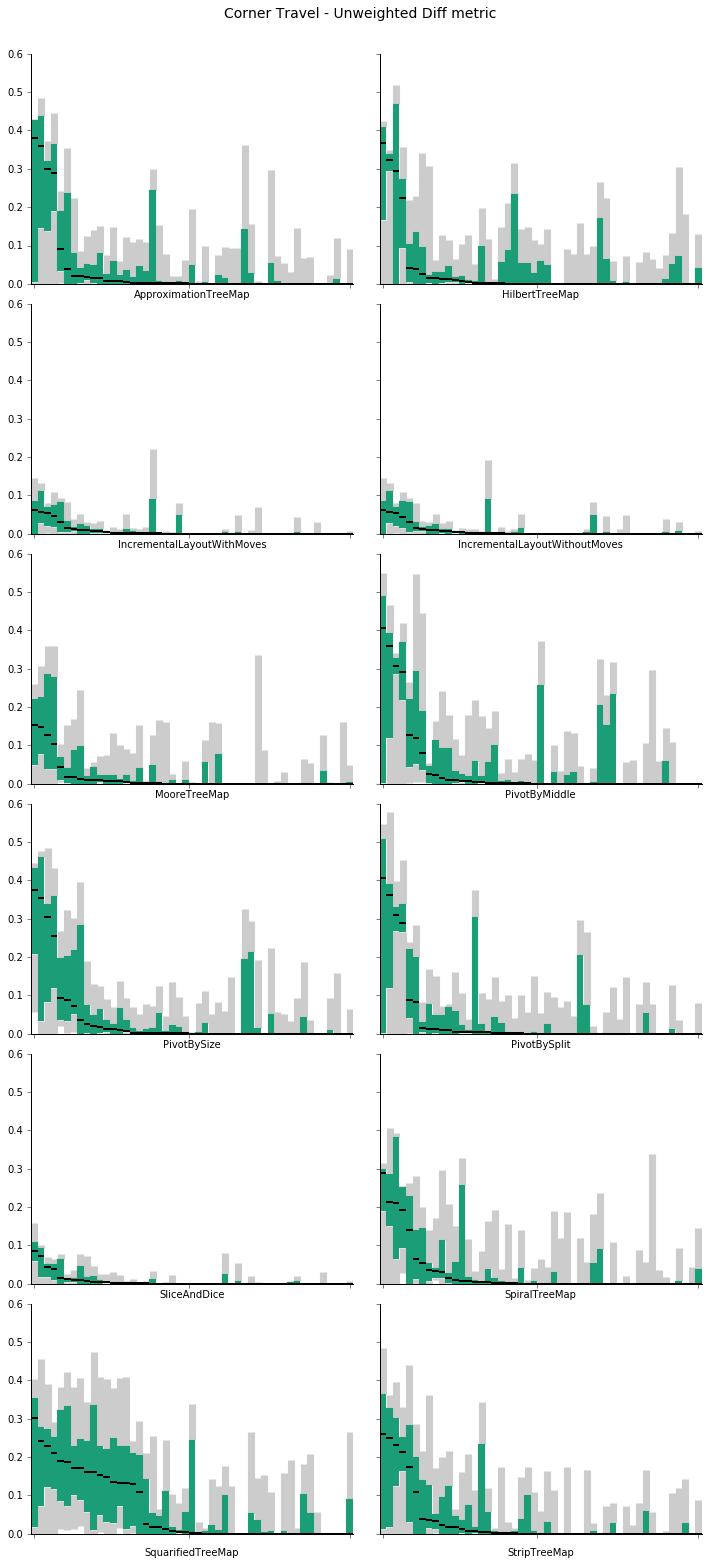

In [94]:
nrow = 6
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, 22))
fig.suptitle('Corner Travel - Unweighted Diff metric', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, ax in enumerate(fig.axes):
    technique = technique_ids[i]
    #ax.set_title(technique)
    ax.set_xlabel(technique)    
    print(technique)

    data = []
    for revision in range(n_revisions - 1):
        bs = baseline_diff_stability(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
                                rectangles[technique][revision + 1][['rx', 'ry', 'rw', 'rh']],
                                rectangles[technique][revision + 1][['bx', 'by', 'bw', 'bh']])
        data.append(bs)
    
    data.sort(key=lambda x: -np.median(x))
    bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);

#     ax.set_ylim(ymin=-0.02, ymax=1)
#     ax.set_yticks([0, .25, .5, .75, 1], minor=False)
#    ax.set_yticklabels([0, .25, .5, .75, 1], fontdict=None, minor=False)
    styleBoxplot(bp, ax, len(data))
    
# s = "Baseline Difference Metric\nDataset: " + dataset_id
# fig.axes[11].text(4, .9, s, fontsize=12)
# # Remove extra spines and ticks
# fig.axes[11].spines['top'].set_visible(False)
# fig.axes[11].spines['bottom'].set_visible(False)
# fig.axes[11].spines['left'].set_visible(False)
# fig.axes[11].spines['right'].set_visible(False)
# fig.axes[11].tick_params(axis='x', which='both', top='off', bottom='off', labelbottom='off')
# fig.axes[11].tick_params(axis='y', which='both', right='off', left='off')
    
# fig.savefig('./boxplots/svg/' + dataset_id + "_bds" + '.svg')
# fig.savefig('./boxplots/png/' + dataset_id + "_bds" + '.png')


In [95]:
# nrow = 6
# ncol = 2
# fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, 22))
# fig.tight_layout()

# for i, ax in enumerate(fig.axes):
#     technique = technique_ids[i]
#     ax.set_title(technique)
#     print(technique)

#     data = []
#     for revision in range(n_revisions - 1):
#         bs = baseline_ratio_stability(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
#                                 rectangles[technique][revision + 1][['rx', 'ry', 'rw', 'rh']],
#                                 rectangles[technique][revision + 1][['bx', 'by', 'bw', 'bh']])
#         data.append(bs)

#     bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);

# #    ax.set_ylim(ymin=-0.02, ymax=1)
# #    ax.set_yticks([0, .25, .5, .75, 1], minor=False)
# #    ax.set_yticklabels([0, .25, .5, .75, 1], fontdict=None, minor=False)
#     styleBoxplot(bp, ax, len(data))

# # s = "Baseline Ratio Metric\nDataset: " + dataset_id
# # fig.axes[11].text(4, .9, s, fontsize=12)
# # # Remove extra spines and ticks
# # fig.axes[11].spines['top'].set_visible(False)
# # fig.axes[11].spines['bottom'].set_visible(False)
# # fig.axes[11].spines['left'].set_visible(False)
# # fig.axes[11].spines['right'].set_visible(False)
# # fig.axes[11].tick_params(axis='x', which='both', top='off', bottom='off', labelbottom='off')
# # fig.axes[11].tick_params(axis='y', which='both', right='off', left='off')
    
# fig.savefig('./boxplots/svg/' + dataset_id + "_brs" + '.svg')
# fig.savefig('./boxplots/png/' + dataset_id + "_brs" + '.png')


In [96]:
# Relative Position Change

In [97]:
#####################################################
# Relative Position Change Metric from 'Stable Treemaps via Local Moves' 2017
#  - Contains a list of the rectangles in the current and in the new iteration. Only those rectangles present in both are there
#    a object in the list should contain "x1","x2","y1","y2" values
def relative_position_change_wrapper(df1, df2):
    df = pd.merge(df1, df2, how='outer', left_index=True, right_index=True)  # Retain only rows in both sets
    df.columns = ['x1', 'y1', 'w1', 'h1', 'x2', 'y2', 'w2', 'h2']
    
    df['w1'] = df['x1'] + df['w1']
    df['h1'] = df['y1'] + df['h1']

    df['w2'] = df['x2'] + df['w2']
    df['h2'] = df['y2'] + df['h2']

    # Coords from 1st revision and coords from 2nd revision
    df.columns = ['x11', 'y11', 'x12', 'y12', 'x21', 'y21', 'x22', 'y22']

    df = get_relative_score(df)
    return df[['rpc']]


def get_relative_score(df):
    N = len(df)
    df['rpc'] = pd.Series(np.zeros(N), index=df.index)

    revision_stability = 0
    for i, r1 in df.iterrows():
        item_stability = 0
        for j, r2 in df.iterrows():
            if i != j:
                old_percentage = getRelativePositions(r1['x11'], r1['x12'], r1['y11'], r1['y12'],
                                                      r2['x11'], r2['x12'], r2['y11'], r2['y12'])
                new_percentage = getRelativePositions(r1['x21'], r1['x22'], r1['y21'], r1['y22'],
                                                      r2['x21'], r2['x22'], r2['y21'], r2['y22'])
                pair_stability = getQuadrantStability(old_percentage, new_percentage)
                item_stability += pair_stability
                revision_stability += pair_stability
        r1['rpc'] = item_stability / (N - 1)

    # revision_stability = revision_stability / (pow(N, 2) - N)
    return df


def getQuadrantStability(percentagesOld, percentagesNew):
   stability = 0
   for i in range(0, 8):
       oldPercentage = percentagesOld[i]
       newPercentage = percentagesNew[i]
       stability += abs(oldPercentage - newPercentage) / 2
   return stability


# gets the relative positions per quadrant from r1 to r2
def getRelativePositions(x11, x12, y11, y12, x21, x22, y21, y22):
    E = 0
    NE = 0
    N = 0
    NW = 0
    W = 0
    SW = 0
    S = 0
    SE = 0

    if (x21 >= x12):
        # Strictly east
        if (y21 < y11):
            # at least partially in NE
            # get the percentage that r2 is in NE
            NE = (y11 - y21) / (y22 - y21)
            NE = min(1, NE)

        if (y22 > y12):
            # at least partiall in SE
            SE = (y22 - y12) / (y22 - y21)
            SE = min(1, SE)

            # remainder is in east
            E = 1 - NE - SE
    elif (x22 <= x11):
        # strictly west
        if (y21 < y11):
            # at least partially in NW
            # get the percentage that r2 is in NW
            NW = (y11 - y21) / (y22 - y21)
            NW = min(1, NW)

        if (y22 > y12):
            # at least partiall in SW
            SW = (y22 - y12) / (y22 - y21)
            SW = min(1, SW)

            # remainder is in west
            W = 1 - NW - SW
    elif (y22 <= y11):
        # strictly North
        if (x21 < x11):
            # at least partially in NW
            # get the percentage that r2 is in NW
            NW = (x11 - x21) / (x22 - x21)
            NW = min(1, NW)

        if (x22 > x12):
            # at least partiall in SW
            NE = (x22 - x12) / (x22 - x21)
            NE = min(1, NE)

            # remainder is in west
            N = 1 - NW - NE
    else:
        # strictly south
        if (x21 < x11):
            # at least partially in SW
            # get the percentage that r2 is in NW
            SW = (x11 - x21) / (x22 - x21)
            SW = min(1, SW)

        if (x22 > x12):
            # at least partiall in SE
            SE = (x22 - x12) / (x22 - x21)
            SE = min(1, SE)

            # remainder is in west
            S = 1 - SW - SE

    quadrant = []
    quadrant.append(E)
    quadrant.append(NE)
    quadrant.append(N)
    quadrant.append(NW)
    quadrant.append(W)
    quadrant.append(SW)
    quadrant.append(S)
    quadrant.append(SE)
    return quadrant

ApproximationTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 HilbertTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 IncrementalLayoutWithMoves
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 IncrementalLayoutWithoutMoves
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 MooreTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 PivotByMiddle
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 PivotBySize
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18

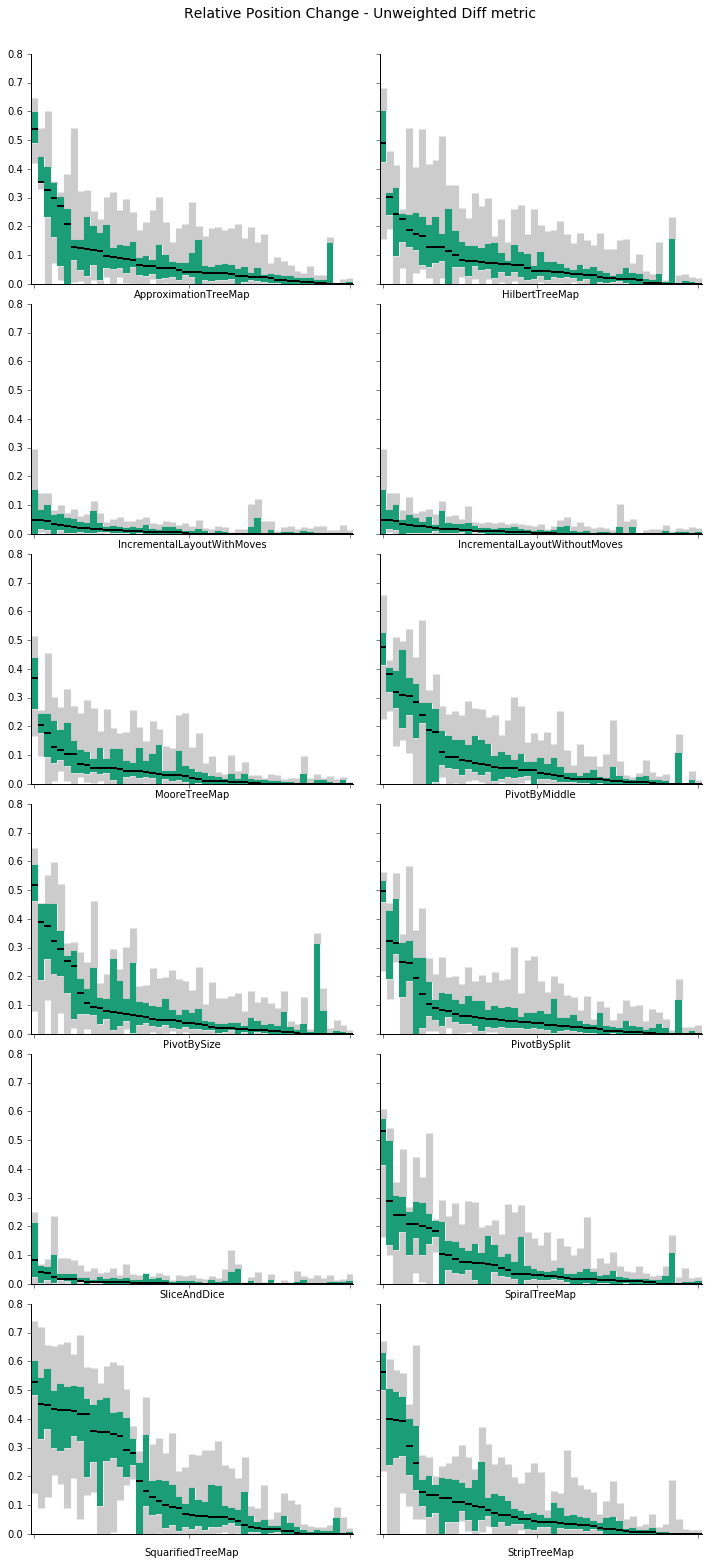

In [98]:
nrow = 6
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, 22))
fig.suptitle('Relative Position Change - Unweighted Diff metric', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)


for i, ax in enumerate(fig.axes):
    technique = technique_ids[i]
    #ax.set_title(technique)
    ax.set_xlabel(technique)    
    print(technique)

    data_diff = []
    data_ratio = []
    
    for revision in range(n_revisions - 1):
        print(revision, end=" ")
        real = relative_position_change_wrapper(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
                                 rectangles[technique][revision+1][['rx', 'ry', 'rw', 'rh']])

        baseline = relative_position_change_wrapper(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
                                 rectangles[technique][revision+1][['bx', 'by', 'bw', 'bh']])

        df = pd.merge(real, baseline, how='outer', left_index=True, right_index=True)
        df.columns = ['rpc_real', 'rpc_baseline']
        df['diff'] = df[['rpc_baseline', 'rpc_real']].max(axis=1) - df['rpc_baseline'] 
        #df['ratio'] = df['rpc_baseline'] / df[['rpc_baseline', 'rpc_real']].min(axis=1)
        data_diff.append(df['diff'].tolist())
        #data_ratio.append(df['ratio'].tolist())
        
    
    data_diff.sort(key=lambda x: -np.median(x))
    bp = ax.boxplot(data_diff, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);

    styleBoxplot(bp, ax, len(data))
    
    
# fig.savefig('./boxplots/svg/' + dataset_id + "_bds" + '.svg')
# fig.savefbig('./boxplots/png/' + dataset_id + "_bds" + '.png')




ApproximationTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 HilbertTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 IncrementalLayoutWithMoves
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 IncrementalLayoutWithoutMoves
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 MooreTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 PivotByMiddle
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 PivotBySize
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18

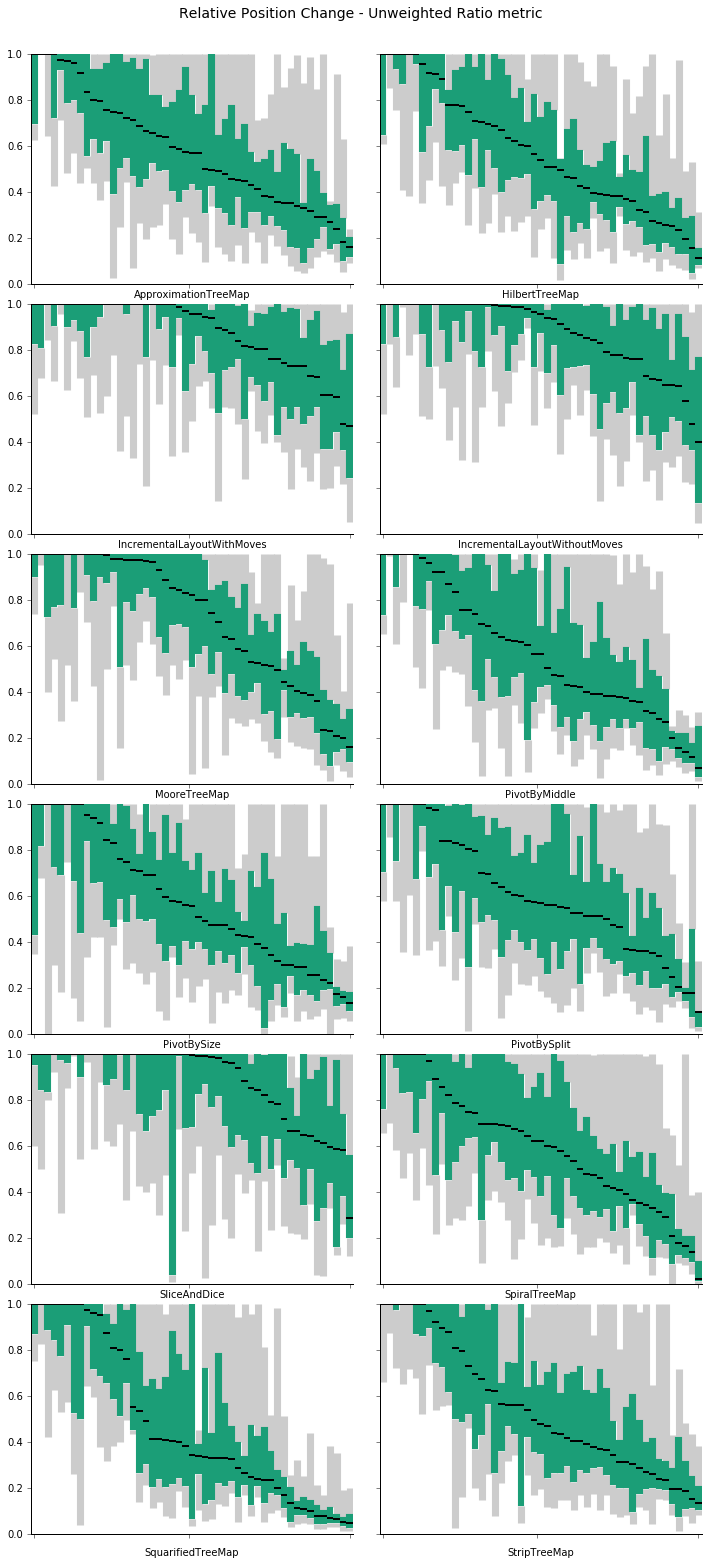

In [99]:
nrow = 6
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, 22))
fig.suptitle('Relative Position Change - Unweighted Ratio metric', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
for i, ax in enumerate(fig.axes):
    technique = technique_ids[i]
    #ax.set_title(technique)
    ax.set_xlabel(technique)    
    print(technique)

    data_ratio = []
    
    for revision in range(n_revisions - 1):
        print(revision, end=" ")
        real = relative_position_change_wrapper(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
                                 rectangles[technique][revision+1][['rx', 'ry', 'rw', 'rh']])

        baseline = relative_position_change_wrapper(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
                                 rectangles[technique][revision+1][['bx', 'by', 'bw', 'bh']])

        df = pd.merge(real, baseline, how='outer', left_index=True, right_index=True)  # Retain only rows in both sets
        df.columns = ['rpc_real', 'rpc_baseline']
        df['ratio'] = df['rpc_baseline'] / df[['rpc_baseline', 'rpc_real']].max(axis=1)
        df = df.fillna(0)
        data_ratio.append(df['ratio'].tolist())
        
    
    data_ratio.sort(key=lambda x: -np.median(x))
    bp = ax.boxplot(data_ratio, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);

    styleBoxplot(bp, ax, len(data))    
    
# fig.savefig('./boxplots/svg/' + dataset_id + "_bds" + '.svg')
# fig.savefig('./boxplots/png/' + dataset_id + "_bds" + '.png')




# Weighted versions


ApproximationTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
HilbertTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
IncrementalLayoutWithMoves
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
IncrementalLayoutWithoutMoves
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
MooreTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
PivotByMiddle
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
PivotBySize
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 1

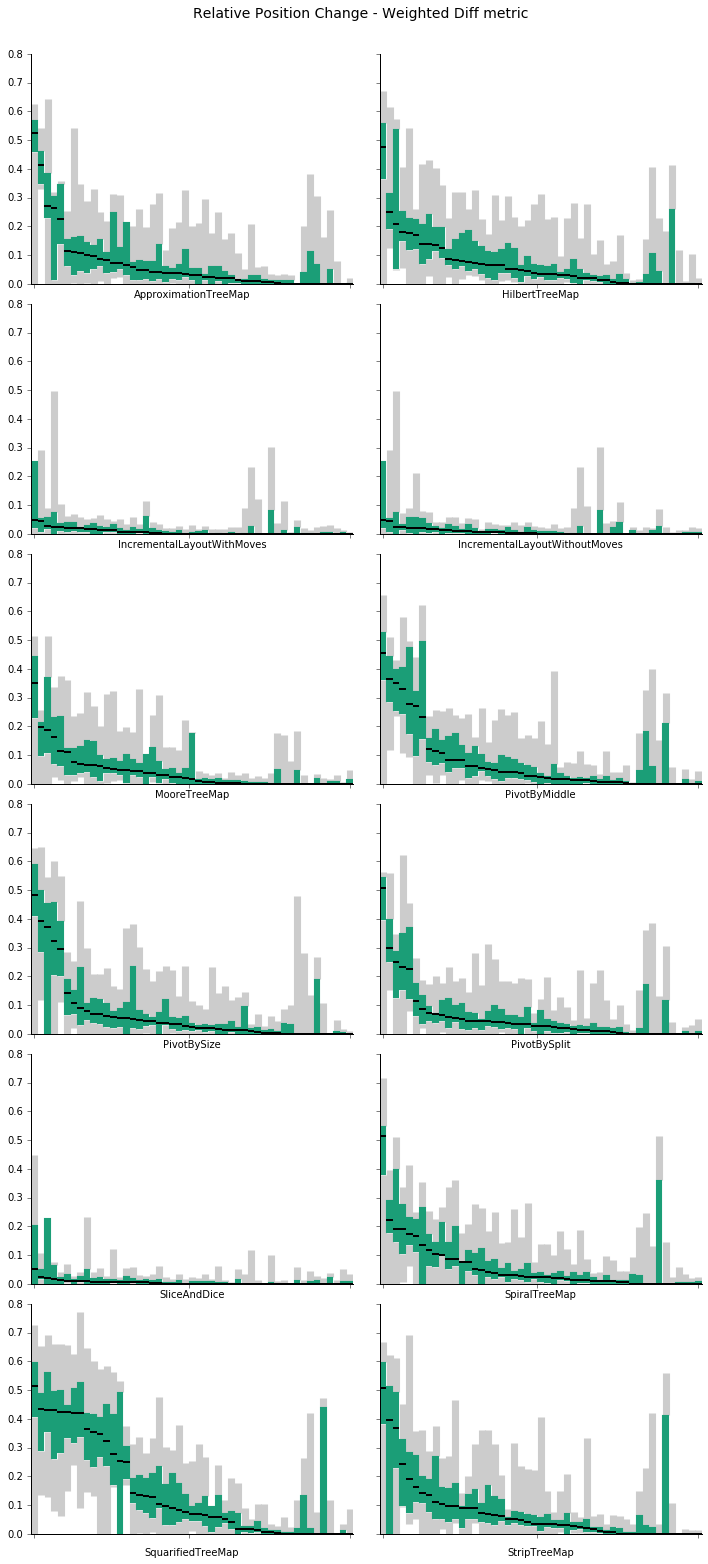

In [100]:
nrow = 6
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, 22))
fig.suptitle('Relative Position Change - Weighted Diff metric', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, ax in enumerate(fig.axes):
    technique = technique_ids[i]
    #ax.set_title(technique)
    ax.set_xlabel(technique)    
    print("")
    print(technique)

    # 5%, first quartile, median, third quartile, 95% statistics lists
    statistics_list = []
    
    for revision in range(n_revisions - 1):
        print(revision, end=" ")

        real = relative_position_change_wrapper(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
                                 rectangles[technique][revision+1][['rx', 'ry', 'rw', 'rh']])

        baseline = relative_position_change_wrapper(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
                                 rectangles[technique][revision+1][['bx', 'by', 'bw', 'bh']])
        
        df = pd.merge(real, baseline, how='inner', left_index=True, right_index=True)  # Retain only rows in both sets
        df.columns = ['rpc_real', 'rpc_baseline']
        df['diff'] = df[['rpc_baseline', 'rpc_real']].max(axis=1) - df['rpc_baseline']
        
        total_area = (rectangles[technique][revision]['rx'] + rectangles[technique][revision]['rw']).max() * (rectangles[technique][revision]['ry'] + rectangles[technique][revision]['rh']).max()
        n_items = len(df)
        df['weight'] = ((rectangles[technique][revision]['rw'] * rectangles[technique][revision]['rh'])) / total_area

        if df['weight'].sum() < 1.0:
            df.loc['insertions_and_deletions'] = [0, 0, 0, 1 - df['weight'].sum()]

        
        df = df.sort_values(by='diff')
        df['weight'] = df['weight'].cumsum()
        
        f = fq = median = tq = nf = float("nan") 
        for i, row in df.iterrows():
            if row['weight'] >= 0.05 and math.isnan(f):
                f = row['diff']
            if row['weight'] >= 0.25 and math.isnan(fq):
                fq = row['diff']
            if row['weight'] >= 0.5 and math.isnan(median):
                median = row['diff']
            if row['weight'] >= 0.75 and math.isnan(tq):
                tq = row['diff']
            if row['weight'] >= 0.95 and math.isnan(nf):
                nf = row['diff']
        
        item = {}
        item["med"] = median
        item["q1"] = fq
        item["q3"] = tq
        item["whislo"] = f
        item["whishi"] = nf
        item["fliers"] = []
        statistics_list.append(item)
        
#         display(df)
#         if revision == 2:
#             break
            
        #df['ratio'] = df['rpc_baseline'] / df[['rpc_baseline', 'rpc_real']].min(axis=1)
        #data_diff.append(df['wighted_diff'].tolist())
        #data_ratio.append(df['ratio'].tolist())
        #break
        
    statistics_list.sort(key=lambda x: -x['med'])
    bp = ax.bxp(statistics_list, showfliers=False, patch_artist=True, widths=1);

    styleBoxplot(bp, ax, len(statistics_list))



ApproximationTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
HilbertTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
IncrementalLayoutWithMoves
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
IncrementalLayoutWithoutMoves
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
MooreTreeMap
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
PivotByMiddle
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
PivotBySize
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 1

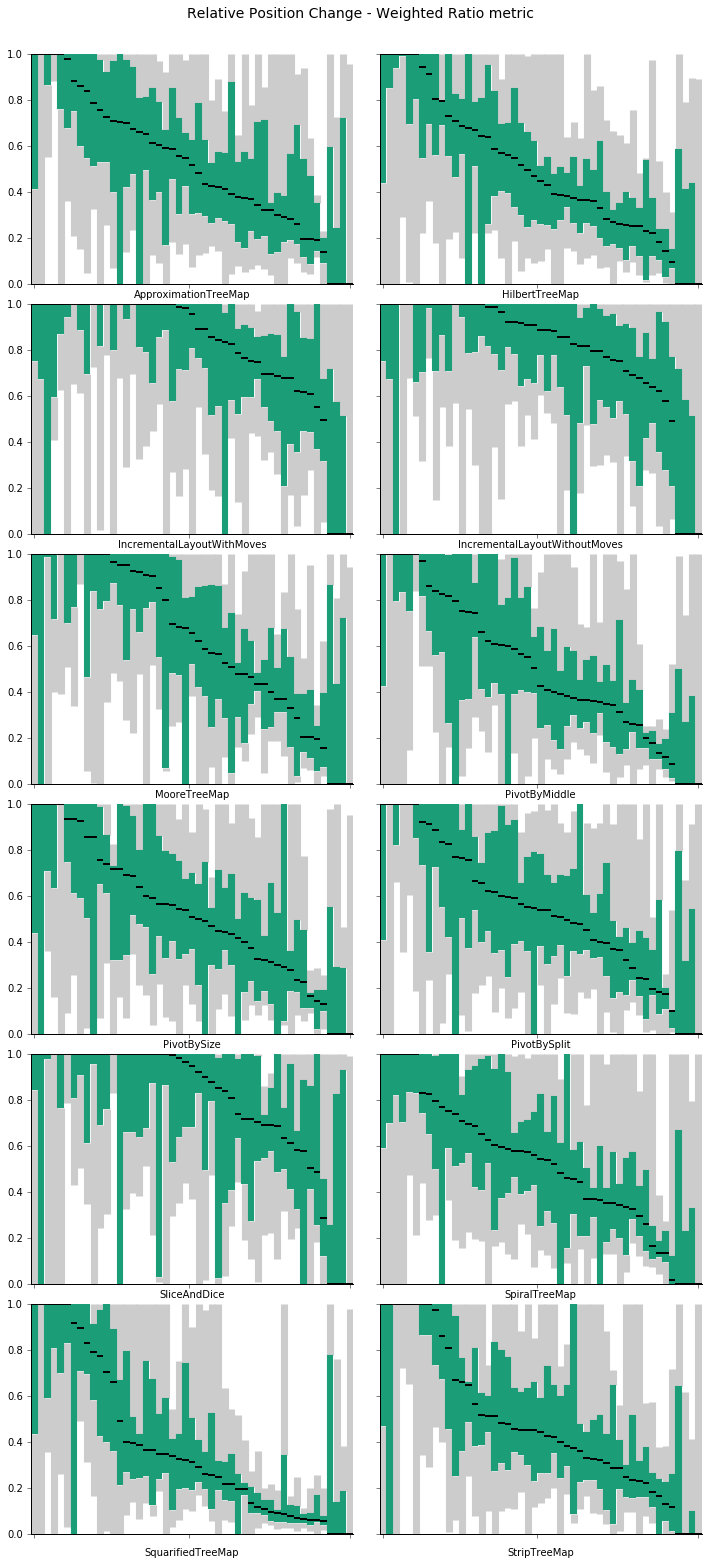

In [101]:
nrow = 6
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, 22))
fig.suptitle('Relative Position Change - Weighted Ratio metric', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, ax in enumerate(fig.axes):
    technique = technique_ids[i]
    #ax.set_title(technique)
    ax.set_xlabel(technique)    
    print("")
    print(technique)

    # 5%, first quartile, median, third quartile, 95% statistics lists
    statistics_list = []
    
    for revision in range(n_revisions - 1):
        print(revision, end=" ")

        real = relative_position_change_wrapper(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
                                 rectangles[technique][revision+1][['rx', 'ry', 'rw', 'rh']])

        baseline = relative_position_change_wrapper(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
                                 rectangles[technique][revision+1][['bx', 'by', 'bw', 'bh']])
        
        df = pd.merge(real, baseline, how='inner', left_index=True, right_index=True)  # Retain only rows in both sets
        df.columns = ['rpc_real', 'rpc_baseline']
        df['ratio'] = df['rpc_baseline'] / df[['rpc_baseline', 'rpc_real']].max(axis=1)
        df = df.fillna(0)
        
        
        total_area = (rectangles[technique][revision]['rx'] + rectangles[technique][revision]['rw']).max() * (rectangles[technique][revision]['ry'] + rectangles[technique][revision]['rh']).max()
        n_items = len(df)
        df['weight'] = ((rectangles[technique][revision]['rw'] * rectangles[technique][revision]['rh'])) / total_area

        if df['weight'].sum() < 1.0:
            df.loc['insertions_and_deletions'] = [0, 0, 0, 1 - df['weight'].sum()]

        
        df = df.sort_values(by='ratio')
        df['weight'] = df['weight'].cumsum()
        
        f = fq = median = tq = nf = float("nan") 
        for i, row in df.iterrows():
            if row['weight'] >= 0.05 and math.isnan(f):
                f = row['ratio']
            if row['weight'] >= 0.25 and math.isnan(fq):
                fq = row['ratio']
            if row['weight'] >= 0.5 and math.isnan(median):
                median = row['ratio']
            if row['weight'] >= 0.75 and math.isnan(tq):
                tq = row['ratio']
            if row['weight'] >= 0.95 and math.isnan(nf):
                nf = row['ratio']
        
        item = {}
        item["med"] = median
        item["q1"] = fq
        item["q3"] = tq
        item["whislo"] = f
        item["whishi"] = nf
        item["fliers"] = []
        statistics_list.append(item)
        
#         display(df)
#         if revision == 2:
#             break
            
        #df['ratio'] = df['rpc_baseline'] / df[['rpc_baseline', 'rpc_real']].min(axis=1)
        #data_diff.append(df['wighted_diff'].tolist())
        #data_ratio.append(df['ratio'].tolist())
        #break
        
    statistics_list.sort(key=lambda x: -x['med'])
    bp = ax.bxp(statistics_list, showfliers=False, patch_artist=True, widths=1);

    styleBoxplot(bp, ax, len(statistics_list))
